In [115]:
import torch

In [116]:
from torch.utils.data import Dataset, DataLoader

In [117]:
import torchvision.transforms as transforms
from torchvision import datasets

In [118]:
mnist_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(1.0))])

In [119]:
trainset = datasets.MNIST(root='/content/',
                          train=True, download=True,
                          transform=mnist_transform)
testset = datasets.MNIST(root='/contnet/',
                         train=False, download=True,
                         transform=mnist_transform)

In [120]:
# num_workers는 사용하는 코어의 수 정도로 생각. 일반적으로 최대 코어의 절반
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=12)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [121]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [122]:
import torch.nn as nn

In [123]:
input = torch.randn(20, 16, 50, 100)
print(input.size())


torch.Size([20, 16, 50, 100])


In [124]:
# dilation
# https://zzsza.github.io/data/2018/02/23/introduction-convolution/
m = nn.Conv2d(16, 33, 3, stride=2)
m = nn.Conv2d(16, 33, (3,5), stride=(2,1), padding=(4,2))
m = nn.Conv2d(16, 33, (3,5), stride=(2,1), padding=(4,2), dilation=(3,1))

In [125]:
output = m(input)
print(output.size())

torch.Size([20, 33, 26, 100])


In [126]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [127]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [128]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

In [129]:
input_data = torch.unsqueeze(images[0], dim=0)
print(input_data.size())
output_data = layer(input_data)
output = output_data.data
output_arr = output.numpy()
output_arr.shape

torch.Size([1, 1, 28, 28])


(1, 20, 24, 24)

In [130]:
import torch.nn.functional as F
pool = F.max_pool2d(output, 2, 2)

In [131]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 20, 12, 12)

In [132]:
input_image = torch.squeeze(images[0])
flatten = input_image.view(1, 28*28)
flatten.shape

torch.Size([1, 784])

In [133]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [134]:
lin

tensor([[ 0.0812,  0.4804,  0.0150,  0.0322,  0.3545, -0.1267,  0.4493,  0.3788,
         -0.6019, -0.1572]], grad_fn=<AddmmBackward0>)

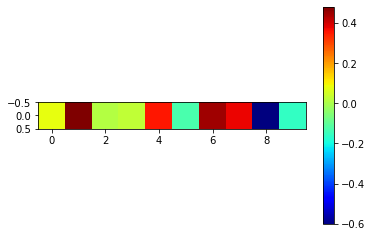

In [135]:
import matplotlib.pyplot as plt
plt.imshow(lin.detach().numpy(), 'jet')
plt.colorbar()
plt.show()

In [136]:
with torch.no_grad():
    flatten = input_image.view(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)
softmax

tensor([[0.0837, 0.1374, 0.0611, 0.0832, 0.1256, 0.0840, 0.1190, 0.0956, 0.1266,
         0.0838]])

In [137]:
import numpy as np
np.sum(softmax.numpy())

0.9999999

In [138]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs = torch.randn(4, 3, 28, 28).to(device)
inputs.shape

torch.Size([4, 3, 28, 28])

In [139]:
layer = nn.Conv2d(3, 20, 5, 1).to(device)
output = F.relu(layer(inputs))
output.shape

torch.Size([4, 20, 24, 24])

In [140]:
class Model(nn.Module):
    def __init__(self, inputs):
        super(Model, self).__init__()
        self.layer = nn.Linear(inputs, 1)
        self.activation = nn.Sigmoid()
        # 정의 부분에서 F.sigmoid는 input 오류가 나옴

    def forward(self, x):
        x = self.layer(x)
        x = self.activation(x)
        return x

In [141]:
model = Model(1)
print(list(model.children()))
print(list(model.modules()))

[Linear(in_features=1, out_features=1, bias=True), Sigmoid()]
[Model(
  (layer): Linear(in_features=1, out_features=1, bias=True)
  (activation): Sigmoid()
), Linear(in_features=1, out_features=1, bias=True), Sigmoid()]


In [142]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 30, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Linear(30*5*5, 10, bias=True),
            nn.ReLU(inplace=True)
        )
        
        def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = x.view(x.shape[0], -1)
            x = self.layer3(x)
            return x

In [143]:
model = Model()
print(list(model.children()))
print(list(model.modules()))

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), Sequential(
  (0): Linear(in_features=750, out_features=10, bias=True)
  (1): ReLU(inplace=True)
)]
[Model(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=750, out_features=10, bias=True)
    (1): ReLU(inplace=True)
  )
), Sequential(
  (

In [144]:
criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

In [145]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


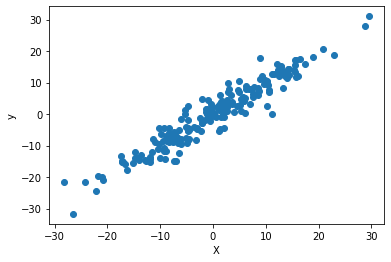

In [146]:
X = torch.randn(200, 1) * 10
y = X + 3 * torch.randn(200, 1)
plt.scatter(X.numpy(), y.numpy())
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [147]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1,1)
    
    def forward(self, x):
        pred = self.linear(x)
        return pred

In [148]:
model = LinearRegressionModel()
print(model)
print(list(model.parameters()))

LinearRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
[Parameter containing:
tensor([[-0.5758]], requires_grad=True), Parameter containing:
tensor([-0.5267], requires_grad=True)]


In [149]:
import torch.optim as optim

criterion= nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [150]:
epochs = 100
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = model(X)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    loss.backward()

    optimizer.step()

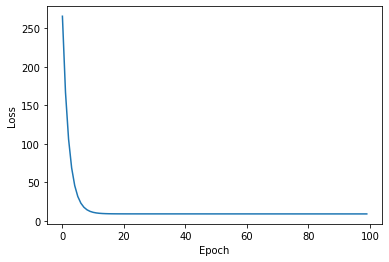

In [151]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [152]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

In [153]:
trainset = datasets.FashionMNIST(root='/content/',
                                 train=True, download=True,
                                 transform=transform)
testset = datasets.FashionMNIST(root='/content/',
                                train=False, download=True,
                                transform=transform)

In [154]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
teset_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


In [155]:
images , labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

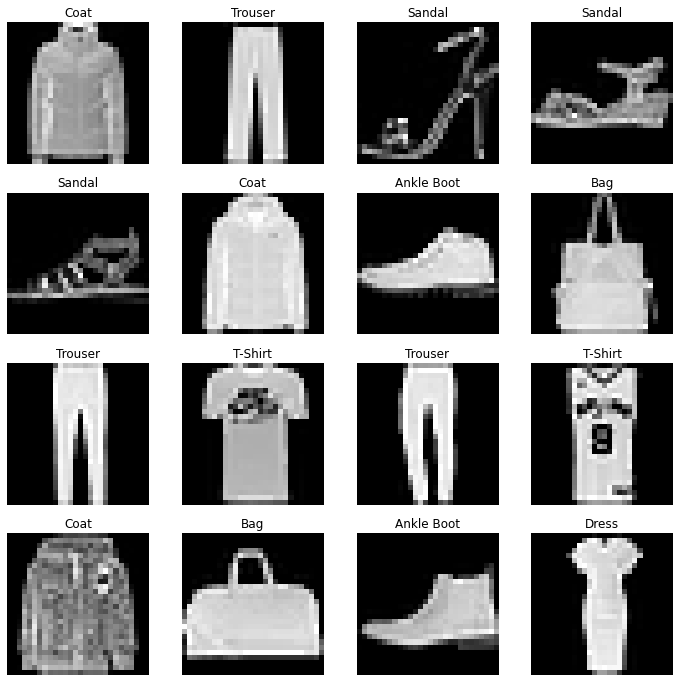

In [156]:
labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    image = images[i].squeeze()
    label_idx = labels[i].item()
    label = labels_map[label_idx]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

In [157]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features=1
        for s in size:
            num_features *= s
        return num_features

net = NeuralNet()
print(net)

NeuralNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [158]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [159]:
input = torch.randn(1, 1, 28, 28)
out = net(input)
print(out)

tensor([[-0.1314,  0.0029,  0.0582, -0.0371, -0.0884,  0.0517,  0.0186,  0.0327,
         -0.0333, -0.0893]], grad_fn=<AddmmBackward0>)


In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [161]:
total_batch = len(train_loader)
print(total_batch)

469


In [162]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99 :
            print('Epoch: {}, iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, iter: 100, Loss: 0.11496016693115234
Epoch: 1, iter: 200, Loss: 0.1142671365737915
Epoch: 1, iter: 300, Loss: 0.11323138737678527
Epoch: 1, iter: 400, Loss: 0.11053645801544189
Epoch: 2, iter: 100, Loss: 0.08184862458705902
Epoch: 2, iter: 200, Loss: 0.05326987683773041
Epoch: 2, iter: 300, Loss: 0.04272576215863228
Epoch: 2, iter: 400, Loss: 0.03881329444050789
Epoch: 3, iter: 100, Loss: 0.034447748154401776
Epoch: 3, iter: 200, Loss: 0.034125894293189046
Epoch: 3, iter: 300, Loss: 0.03316303415596485
Epoch: 3, iter: 400, Loss: 0.03219652181863785
Epoch: 4, iter: 100, Loss: 0.03043183434009552
Epoch: 4, iter: 200, Loss: 0.030575245320796966
Epoch: 4, iter: 300, Loss: 0.029575518652796746
Epoch: 4, iter: 400, Loss: 0.029287735104560852
Epoch: 5, iter: 100, Loss: 0.028898251980543136
Epoch: 5, iter: 200, Loss: 0.028199090152978896
Epoch: 5, iter: 300, Loss: 0.027432025983929634
Epoch: 5, iter: 400, Loss: 0.02765471662580967
Epoch: 6, iter: 100, Loss: 0.02722943465411663
Epoch: